<a href="https://colab.research.google.com/github/MuftiqurBista1111/Unisnacks_Data_Forecasting/blob/main/Forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
# import pmdarima as pm
import itertools
import math
import matplotlib.pyplot as plt


from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
data = pd.read_csv("/content/Sales Order Custom Search Bista Results - 747 - Revised.csv", parse_dates=True)


In [3]:

data_new = data.loc[:,['Customer Name','Date','Quantity','Item : Internal ID']]
data_new.rename(columns={'Item : Internal ID': 'Product_Id', 'Name':'Customer_Name'}, inplace=True)
# Drop rows with NaN values in Product_Id column
data_new.dropna(subset=['Product_Id'], inplace=True)

result = data_new.groupby(['Customer Name', 'Product_Id', 'Date', 'Quantity']).size().reset_index()

In [ ]:
type(result)

In [ ]:
# def get_customer_product_data(data):
#     # Initialize an empty dictionary to store customer-wise dataframes
#     customer_dataframes = {}

#     # Iterate over unique customers
#     unique_customers = data['Customer Name'].unique()
#     for customer in unique_customers:
#         # Filter data for the current customer
#         customer_data = data[data['Customer Name'] == customer]

#         # Iterate over unique products purchased by the customer
#         unique_products = customer_data['Product_Id'].unique()
#         for product in unique_products:
#             # Filter data for the current product
#             product_data = customer_data[customer_data['Product_Id'] == product]

#             # Extract date and quantity information for the product
#             product_sales_data = product_data[['Date', 'Quantity']]

#             # Add the product sales data to the dictionary using customer and product as keys
#             customer_dataframes[(customer, product)] = product_sales_data

#     return customer_dataframes

# # Call the function to get the customer-wise product data
# customer_product_data = get_customer_product_data(result)

# # Function to display customer list and their product lists
# def display_customer_product_list(customer_product_data):
#     for customer_product, data_frame in customer_product_data.items():
#         customer, product = customer_product
#         print(f"Customer: {customer}, Product: {product}")
#         print(data_frame)
#         print("\n")

# # Call the function to display the customer-wise product lists
# display_customer_product_list(customer_product_data)


In [4]:
# Define your function to load and preprocess data
def preprocess_data(file_path):
    # Load data
    data = pd.read_csv(file_path, parse_dates=True)

    # Select relevant columns and rename
    data_new = data.loc[:,['Customer Name','Date','Quantity','Item : Internal ID']]
    data_new.rename(columns={'Item : Internal ID': 'Product_Id', 'Customer Name':'Customer_Name'}, inplace=True)

    # Drop rows with NaN values in Product_Id column
    data_new.dropna(subset=['Product_Id'], inplace=True)

    # Group by Customer Name, Product_Id, Date, and Quantity
    result = data_new.groupby(['Customer_Name', 'Product_Id', 'Date', 'Quantity']).size().reset_index()

    return result

In [5]:
def get_customer_product_data(data):
    # Initialize an empty dictionary to store customer-wise dataframes
    customer_dataframes = {}

    # Initialize empty lists to store customer names and product IDs with more than 15 entries
    selected_customers = []
    selected_products = []

    # Iterate over unique customers
    unique_customers = data['Customer_Name'].unique()
    for customer in unique_customers:
        # Filter data for the current customer
        customer_data = data[data['Customer_Name'] == customer]

        # Iterate over unique products purchased by the customer
        unique_products = customer_data['Product_Id'].unique()
        for product in unique_products:
            # Filter data for the current product
            product_data = customer_data[customer_data['Product_Id'] == product]

            # Check if the number of entries for the product is more than 15
            if len(product_data) > 15:
                # Extract date and quantity information for the product
                product_sales_data = product_data[['Date', 'Quantity']]

                # Add the customer and product to selected lists
                selected_customers.append(customer)
                selected_products.append(product)

                # Add the product sales data to the dictionary using customer and product as keys
                customer_dataframes[(customer, product)] = product_sales_data

    return selected_customers, selected_products, customer_dataframes


In [6]:
# Load and preprocess your data (replace 'file_path' with your actual file path)
file_path = "/content/Sales Order Custom Search Bista Results - 747 - Revised.csv"
result = preprocess_data(file_path)

# Get selected customers and products
selected_customers, selected_products, customer_product_data = get_customer_product_data(result)

# Display selected customers and products
print("Customers and Product IDs with total sales quantity more than 15:")
for customer, product in zip(selected_customers, selected_products):
    print(f"Customer: {customer}, Product: {product}")

Customers and Product IDs with total sales quantity more than 15:
Customer: BXX009 Vanguard UK Trading Ltd, Product: 918.0
Customer: BXX009 Vanguard UK Trading Ltd, Product: 920.0
Customer: BXX009 Vanguard UK Trading Ltd, Product: 922.0
Customer: BXX009 Vanguard UK Trading Ltd, Product: 925.0
Customer: BXX009 Vanguard UK Trading Ltd, Product: 1049.0
Customer: BXX010 W Wing Yip PLC (Birmingham), Product: 706.0
Customer: ECX002 Sainsbury's Supermarkets Ltd, Product: 918.0
Customer: ECX002 Sainsbury's Supermarkets Ltd, Product: 925.0
Customer: EXX017 Longdan LTD, Product: 442.0
Customer: EXX017 Longdan LTD, Product: 463.0
Customer: EXX017 Longdan LTD, Product: 481.0
Customer: EXX017 Longdan LTD, Product: 918.0
Customer: EXX017 Longdan LTD, Product: 920.0
Customer: EXX017 Longdan LTD, Product: 922.0
Customer: EXX017 Longdan LTD, Product: 923.0
Customer: EXX017 Longdan LTD, Product: 925.0
Customer: EXX017 Longdan LTD, Product: 942.0
Customer: EXX017 Longdan LTD, Product: 943.0
Customer: EXX

In [10]:
def get_customer_product_dataframe(customer, product, customer_product_data):
    return customer_product_data.get((customer, product), None)

# Example: Select a specific customer and product
selected_customer = "WXX011 Natural Natural Ealing"
selected_product = 455.0

# Get date and quantity DataFrame for the selected customer and product
selected_dataframe = get_customer_product_dataframe(selected_customer, selected_product, customer_product_data)

# Update the 'Quantity' column of selected_dataframe to have all values as 1
selected_dataframe['Quantity'] = 1

# Print the DataFrame
if selected_dataframe is not None:
    print(f"\nDate and Quantity DataFrame for Customer: {selected_customer}, Product: {selected_product}:")
    print(selected_dataframe)
else:
    print(f"No data found for Customer: {selected_customer}, Product: {selected_product}")



Date and Quantity DataFrame for Customer: WXX011 Natural Natural Ealing, Product: 455.0:
             Date  Quantity
47876  02/07/2019         1
47877  04/10/2019         1
47878  08/04/2019         1
47879  08/05/2019         1
47880  09/07/2019         1
47881  09/10/2019         1
47882  10/06/2019         1
47883  11/05/2020         1
47884  12/03/2020         1
47885  12/04/2020         1
47886  13/01/2020         1
47887  15/11/2019         1
47888  16/07/2019         1
47889  16/09/2019         1
47890  17/04/2019         1
47891  18/02/2020         1
47892  20/08/2019         1
47893  21/05/2019         1
47894  21/10/2019         1
47895  27/11/2019         1
47896  29/10/2019         1
47897  30/07/2019         1
47898  31/03/2020         1
47899  31/05/2019         1
47900  31/12/2019         1


In [11]:
print(selected_dataframe.columns)

Index(['Date', 'Quantity'], dtype='object')


In [ ]:
type(selected_dataframe)

In [ ]:
df.dtypes

Date        datetime64[ns]
Quantity             int64
dtype: object

In [ ]:
selected_dataframe.dtypes

Date         object
Quantity    float64
dtype: object

In [12]:
print(len(selected_dataframe.columns))#len() method

2


In [13]:
import datetime
from dateutil.relativedelta import relativedelta

# Define the operation to create a DataFrame for 5 years data with all zeros
today = datetime.date.today()
end_date = today.replace(day=1) - datetime.timedelta(days=1)
start_date = end_date + relativedelta(years=-5)
date_range = pd.date_range(start=start_date, end=end_date, freq="M")
new_df = pd.DataFrame({'Date': date_range.strftime('%d/%m/%Y'), 'Quantity': 0.00})

# Convert 'Date' column to object data type
new_df['Date'] = new_df['Date'].astype('object')

# Convert 'Quantity' column to float64 data type
new_df['Quantity'] = new_df['Quantity'].astype('float64')

# Print the new DataFrame
print("New DataFrame:")
print(new_df)


New DataFrame:
          Date  Quantity
0   30/04/2019       0.0
1   31/05/2019       0.0
2   30/06/2019       0.0
3   31/07/2019       0.0
4   31/08/2019       0.0
..         ...       ...
56  31/12/2023       0.0
57  31/01/2024       0.0
58  29/02/2024       0.0
59  31/03/2024       0.0
60  30/04/2024       0.0

[61 rows x 2 columns]


In [14]:
# Merge new_df with selected_dataframe
merged_df = pd.concat([new_df, selected_dataframe], ignore_index=True)

# Convert 'Date' column to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%d/%m/%Y')

# Fill NaN values with 0.00 for Quantity
merged_df['Quantity'].fillna(0.00, inplace=True)

# Sort the DataFrame by the 'Date' column
merged_df = merged_df.sort_values(by='Date')

# Print the merged and sorted DataFrame
print("Merged and Sorted DataFrame:")
print(merged_df)


Merged and Sorted DataFrame:
         Date  Quantity
63 2019-04-08       1.0
75 2019-04-17       1.0
0  2019-04-30       0.0
64 2019-05-08       1.0
78 2019-05-21       1.0
..        ...       ...
56 2023-12-31       0.0
57 2024-01-31       0.0
58 2024-02-29       0.0
59 2024-03-31       0.0
60 2024-04-30       0.0

[86 rows x 2 columns]


In [15]:
merged_df

,Date,Quantity
63,2019-04-08,1.0
75,2019-04-17,1.0
0,2019-04-30,0.0
64,2019-05-08,1.0
78,2019-05-21,1.0
...,...,...
56,2023-12-31,0.0
57,2024-01-31,0.0
58,2024-02-29,0.0
59,2024-03-31,0.0


from matplotlib import pyplot as plt
merged_df['Quantity'].plot(kind='hist', bins=20, title='Quantity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Quantity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Quantity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Quantity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Quantity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
merged_df['Quantity'].plot(kind='line', figsize=(8, 4), title='Quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

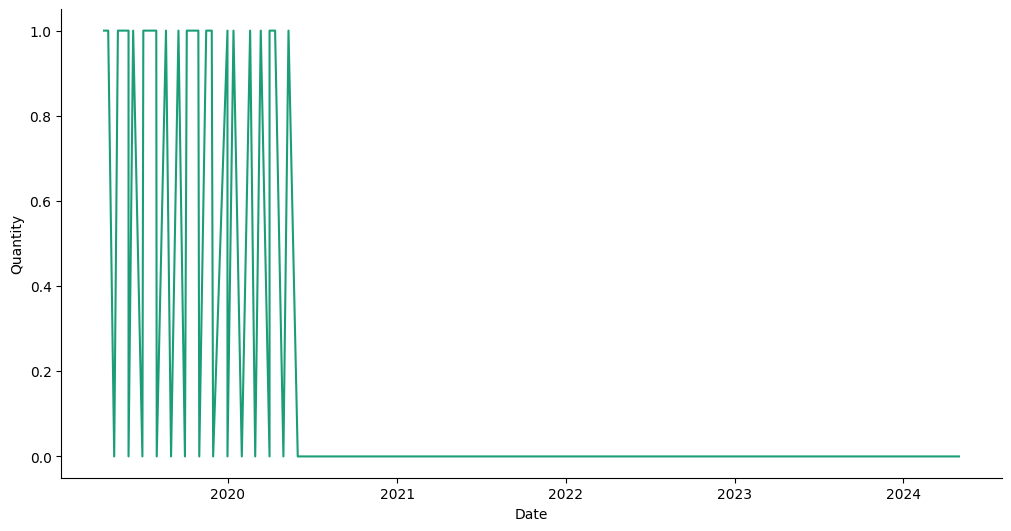

In [16]:
# @title Date vs Quantity

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Quantity']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Quantity')

Epoch 1/50
9/9 [==============================] - 5s 15ms/step - loss: 0.2305
Epoch 2/50
9/9 [==============================] - 0s 13ms/step - loss: 0.1661
Epoch 3/50
9/9 [==============================] - 0s 12ms/step - loss: 0.1339
Epoch 4/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1321
Epoch 5/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1268
Epoch 6/50
9/9 [==============================] - 0s 13ms/step - loss: 0.1259
Epoch 7/50
9/9 [==============================] - 0s 13ms/step - loss: 0.1242
Epoch 8/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1210
Epoch 9/50
9/9 [==============================] - 0s 12ms/step - loss: 0.1253
Epoch 10/50
9/9 [==============================] - 0s 12ms/step - loss: 0.1218
Epoch 11/50
9/9 [==============================] - 0s 14ms/step - loss: 0.1217
Epoch 12/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1216
Epoch 13/50
9/9 [==============================] - 0s 11ms/st

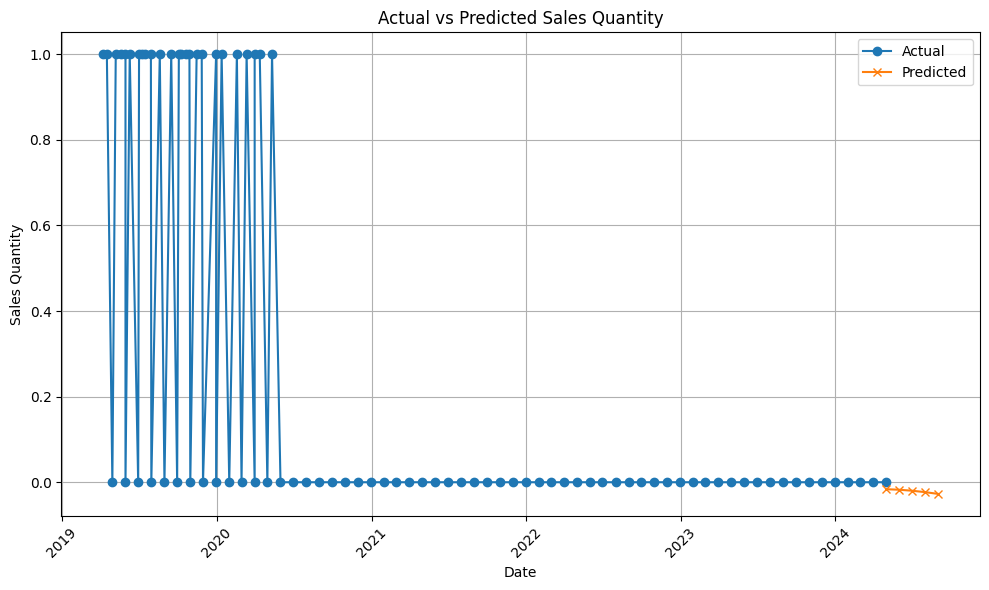

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Convert merged_df to a numpy array
data = merged_df['Quantity'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 5

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Reshape input data to be 3D for LSTM [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=10, verbose=1)

# Make predictions for the next 5 months
next_5_months = pd.date_range(merged_df['Date'].iloc[-1], periods=5, freq='M')
next_5_months_scaled = scaler.transform(np.zeros((5, 1)))
next_5_months_X = np.reshape(next_5_months_scaled, (1, seq_length, 1))
predictions_scaled = []

for _ in range(5):
    next_prediction_scaled = model.predict(next_5_months_X)
    predictions_scaled.append(next_prediction_scaled)
    next_5_months_X = np.roll(next_5_months_X, -1)
    next_5_months_X[0, -1] = next_prediction_scaled

# Inverse transform the scaled predictions
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Quantity'], label='Actual', marker='o')
plt.plot(next_5_months, predictions, label='Predicted', marker='x')
plt.title('Actual vs Predicted Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
print(X.shape)

(81, 5, 1)


In [18]:
# Print the predicted quantity with date for the next 5 months
print("Predicted Quantity for the Next 5 Months:")
for i in range(len(next_5_months)):
    print(f"{next_5_months[i].strftime('%Y-%m-%d')}: {predictions[i][0]}")


Predicted Quantity for the Next 5 Months:
2024-04-30: -0.016342803835868835
2024-05-31: -0.01751844212412834
2024-06-30: -0.019838888198137283
2024-07-31: -0.023153986781835556
2024-08-31: -0.02730618044734001


In [ ]:
new_df.dtypes

Date         object
Quantity    float64
dtype: object

In [ ]:
merged_df.dtypes

Date        datetime64[ns]
Quantity           float64
dtype: object

In [ ]:
print("Column names of merged_df:")
print(merged_df.columns)


Column names of merged_df:
Index(['Date', 'Quantity'], dtype='object')


In [ ]:
print("Column names of df:")
print(df.columns)

print("\nColumn names of selected_dataframe:")
print(selected_dataframe.columns)


Column names of df:
Index(['Date', 'Quantity'], dtype='object')

Column names of selected_dataframe:
Index(['Date', 'Quantity'], dtype='object')
